In [120]:
import matplotlib.pyplot as plt
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors
import safe as sf
import io
from PIL import Image
from matplotlib.patches import Rectangle
from textwrap import fill

In [96]:
def read_smiles_data(file_path):
    return pd.read_csv(file_path, header=None)[0]

In [97]:
safe_small = read_smiles_data("Results/SAFE_GPT_20M_10000_samples.txt")
safe_large = read_smiles_data("Results/SAFE_GPT_large_generated_smiles_10k.txt")
mamba_small = read_smiles_data("Results/SSM_20M_little_dropout_10000_samples.txt")
mamba_large = read_smiles_data("Results/SSM_100M_10000_samples.txt")
mamba_small_hybrid = read_smiles_data("Results/HYBRID_20M_dropout_little_10000_samples.txt")


In [98]:
datasets = {
    'SAFE Small': safe_small,
    'SAFE Large': safe_large,
    'Mamba Small': mamba_small,
    'Mamba Large': mamba_large,
    'Mamba Small Hybrid': mamba_small_hybrid
}

In [99]:
def get_representative_molecules(smiles_list):
    longest = max(smiles_list, key=len)
    shortest = min(smiles_list, key=len)
    
    highest_qed_smiles = max(smiles_list, key=lambda s: Descriptors.qed(Chem.MolFromSmiles(s)) if Chem.MolFromSmiles(s) else 0)
    highest_qed_value = Descriptors.qed(Chem.MolFromSmiles(highest_qed_smiles))
    
    return {
        'Longest': longest,
        'Shortest': shortest,
        'Most Diverse': smiles_list[len(smiles_list) // 2],
        'Highest QED': highest_qed_smiles,
        'Highest QED Value': highest_qed_value
    }

In [124]:
def create_molecule_plot(model_name, smiles_list):
    rep_mols = get_representative_molecules(smiles_list)
    categories = ['Longest', 'Shortest', 'Most Diverse', 'Highest QED']
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 7))
    fig.suptitle(f"{model_name}", fontsize=24, fontweight='bold', y=0.98)
    
    fig.add_artist(Rectangle((0.1, 0.93), 0.8, 0.002, fill=True, transform=fig.transFigure, figure=fig))
    
    for idx, category in enumerate(categories):
        smiles = rep_mols[category]
        mol = Chem.MolFromSmiles(smiles)
        img = Draw.MolToImage(mol, size=(400, 400))
        
        axes[0, idx].imshow(img)
        axes[0, idx].axis('off')
        axes[0, idx].set_title(category, fontsize=16, fontweight='bold')
        
        safe_encoded = sf.encode(smiles)
        
        # Wrap text at a reasonable length
        text = f"SMILES:\n{fill(smiles, width=50)}\n\nSAFE:\n{fill(safe_encoded, width=50)}"
        if category == 'Highest QED':
            text += f"\n\nQED: {rep_mols['Highest QED Value']:.4f}"
        
        text = text.replace("SMILES:", r"$\bf{SMILES}$:")
        text = text.replace("SAFE:", r"$\bf{SAFE}$:")
        
        axes[1, idx].text(0.5, 0.95, text, ha='center', va='top', wrap=True, fontsize=12)
        axes[1, idx].axis('off')
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


In [125]:
for model_name, smiles_list in datasets.items():
    fig = create_molecule_plot(model_name, smiles_list)
    plt.savefig(f'{model_name.replace(" ", "_")}_molecules.png', dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f"Plot for {model_name} saved.")

Plot for SAFE Small saved.
Plot for SAFE Large saved.
Plot for Mamba Small saved.
Plot for Mamba Large saved.
Plot for Mamba Small Hybrid saved.


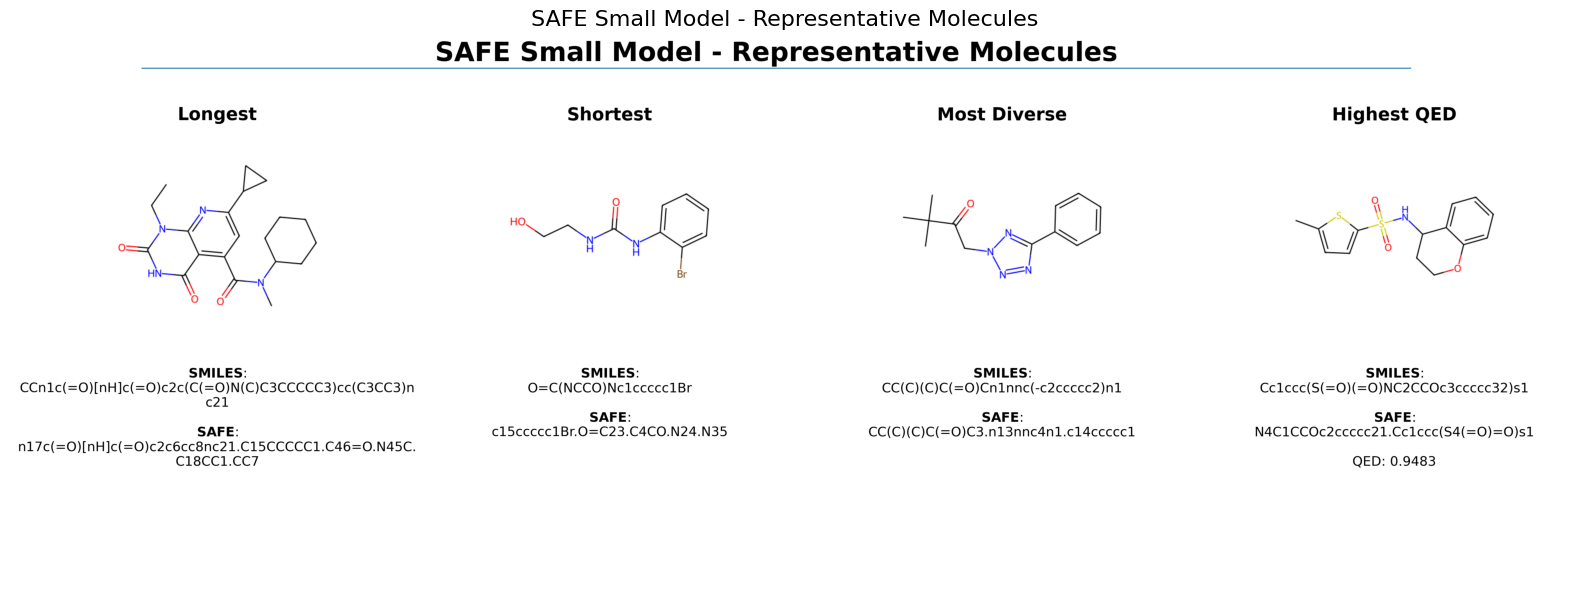

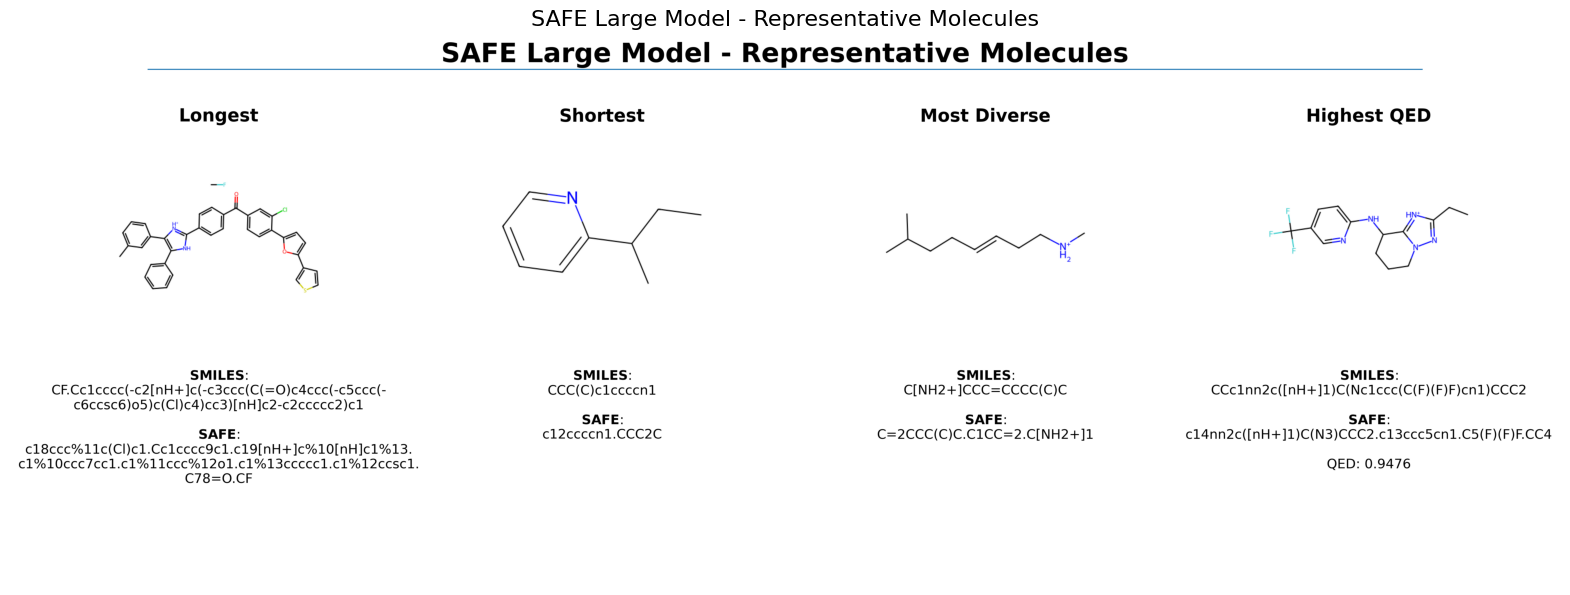

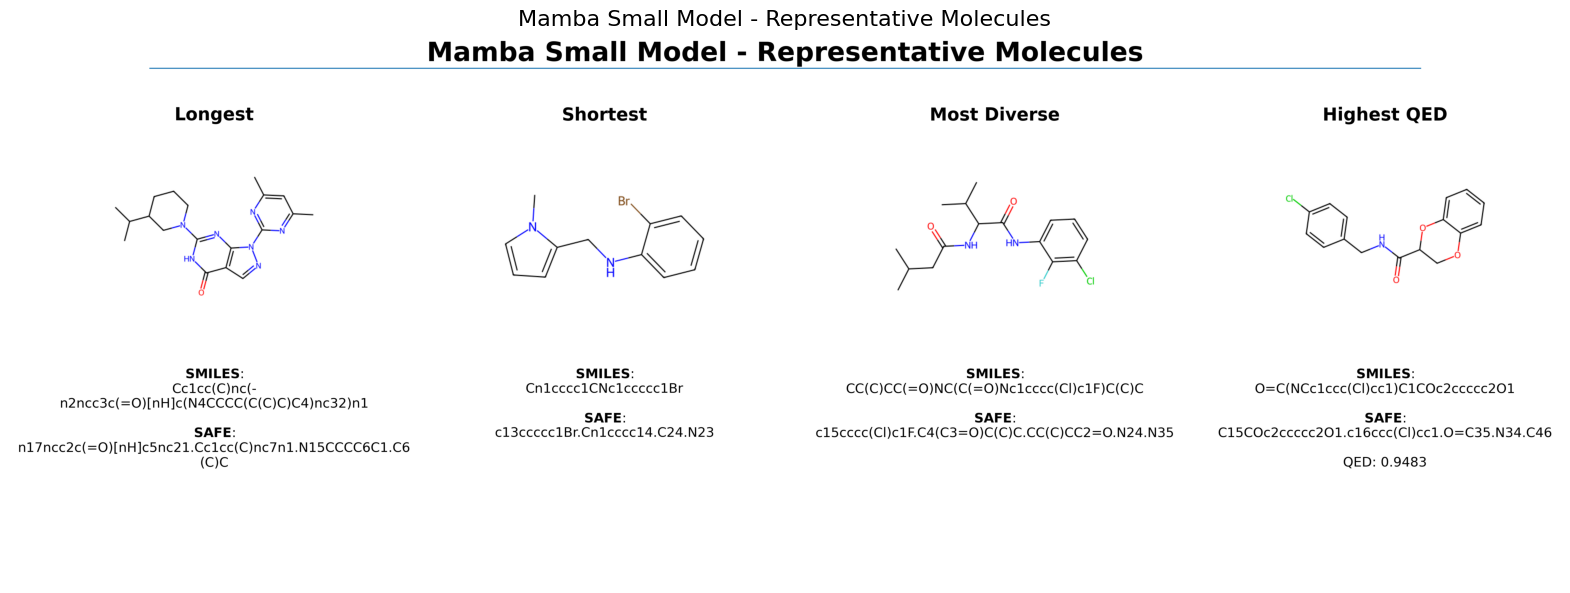

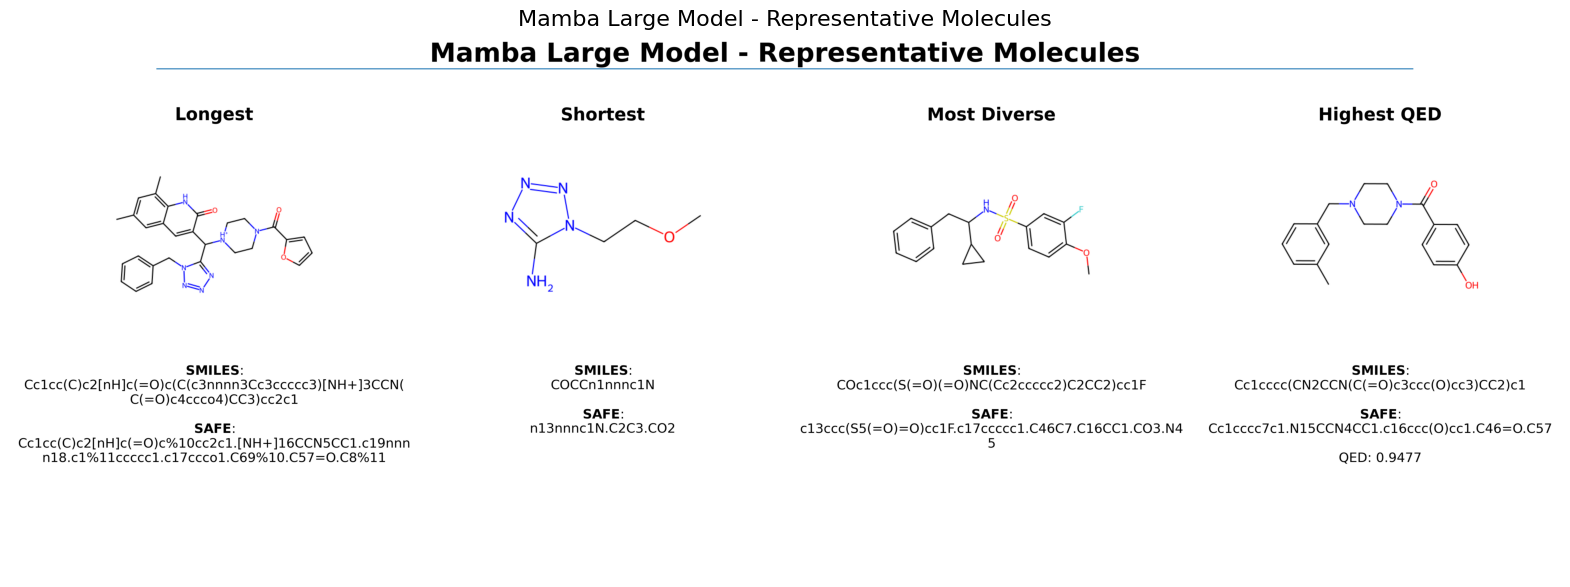

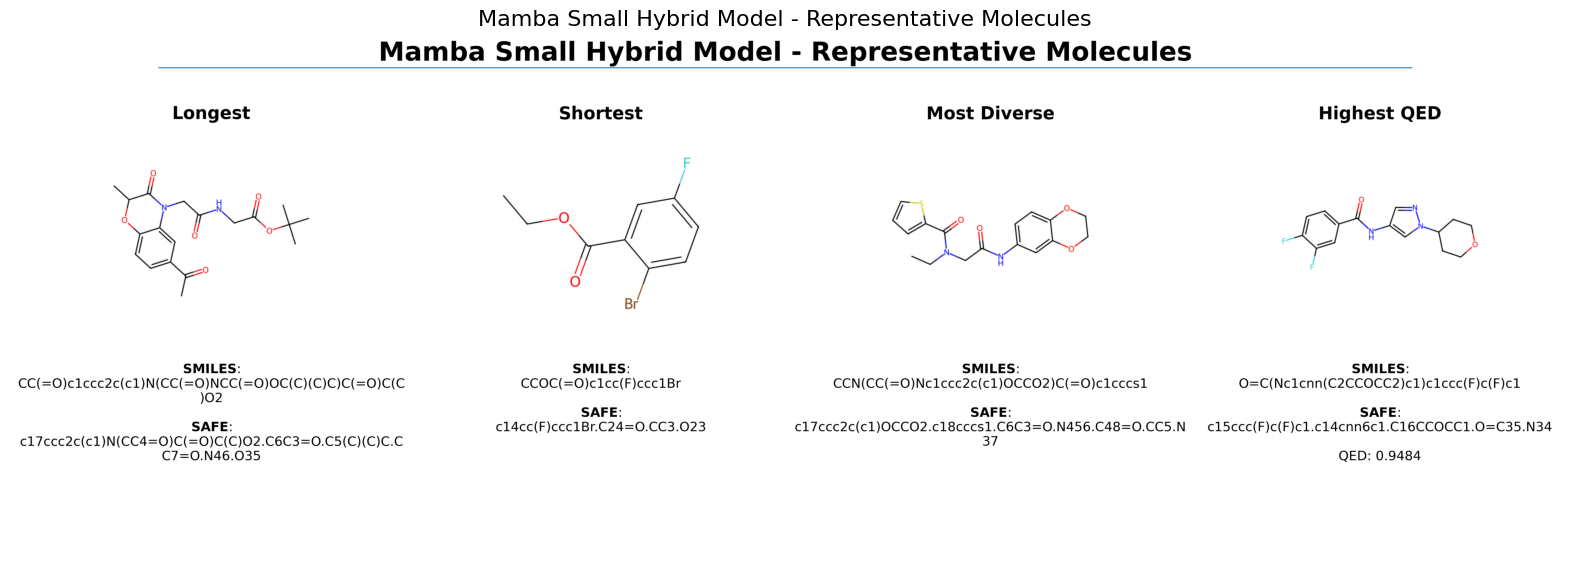

In [123]:
for model_name in datasets.keys():
    img = Image.open(f'{model_name.replace(" ", "_")}_molecules.png')
    plt.figure(figsize=(20, 10))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{model_name} Model - Representative Molecules", fontsize=16)
    plt.show()